In [1]:
#import moduli necessari per l'esecuzione

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#importazione del file CSV
df = pd.read_csv('falldetection.csv')

#tabella riassuntiva dei dati
df.describe()


,ACTIVITY,TIME,SL,EEG,BP,HR,CIRCLUATION
count,16382.000000,16382.000000,1.638200e+04,1.638200e+04,16382.000000,16382.000000,16382.000000
mean,2.361494,10936.842478,7.527198e+04,-5.621125e+03,58.251068,211.536992,2894.341472
std,1.739195,5261.463601,1.275022e+05,1.082209e+05,48.292926,129.949521,3825.927830
min,0.000000,1954.230000,4.222420e+01,-1.262600e+07,0.000000,33.000000,5.000000
25%,0.000000,7263.685000,9.941170e+03,-5.630000e+03,25.000000,119.000000,587.000000
50%,3.000000,9769.355000,3.118920e+04,-3.361275e+03,44.000000,180.000000,1581.000000
75%,4.000000,13481.650000,8.076145e+04,-2.150000e+03,78.000000,271.000000,3539.000000
max,5.000000,50895.500000,2.426140e+06,1.410000e+06,533.000000,986.000000,52210.000000


In [ ]:
#cancellazione eventuali dati nulli tramite metodo dropna() 
#implace = True per cancellare direttamente i valori nulli e tirornare None: cio 
#permette di non dover salvare il risultato in una variabile nuova ma eseguirlo direttamente sul dataFrame

len_df = len(df)
df.dropna(inplace=True) 
len_after_df = len(df)

if len(df) == len(df.dropna()):
    print("Non sono stasti trovati dati nulli")
else:
    print("Sono stati trovati " + str(len_df - len_after_df) + " nulli")



In [ ]:
#scalare i dati su dati reali.
#massimo HR registrato in un essere umano è pari a 208 BPM: applico funzione MinMixScaler con un range da 33 a 208
#la funzione richiede un Numpy array e quindi converto prima la colonna df['HR']
from sklearn.preprocessing import MinMaxScaler

hr_data = df['HR'].astype(float).to_numpy().reshape(-1, 1)
min_max_scaler = MinMaxScaler(copy=True, feature_range=(33, 208))
hr_data_minmax = min_max_scaler.fit_transform(hr_data)
print(hr_data_minmax)

df['HR'] = hr_data_minmax

df.describe()

In [ ]:
#diamo un nome reale alle classi e 

fd = df.replace({'ACTIVITY':{0:'Standing', 1:'Walking', 2:'Sitting', 3:'Falling', 4:'Cramps', 5:'Running'}})
fd.head(25)

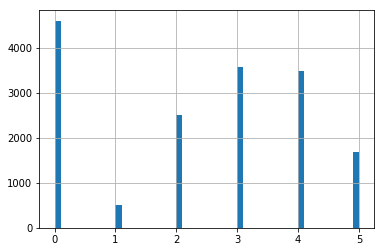

In [7]:
#creazione grafico per osservare il cout di dari per ogni classe
df['ACTIVITY'].hist(bins=50)

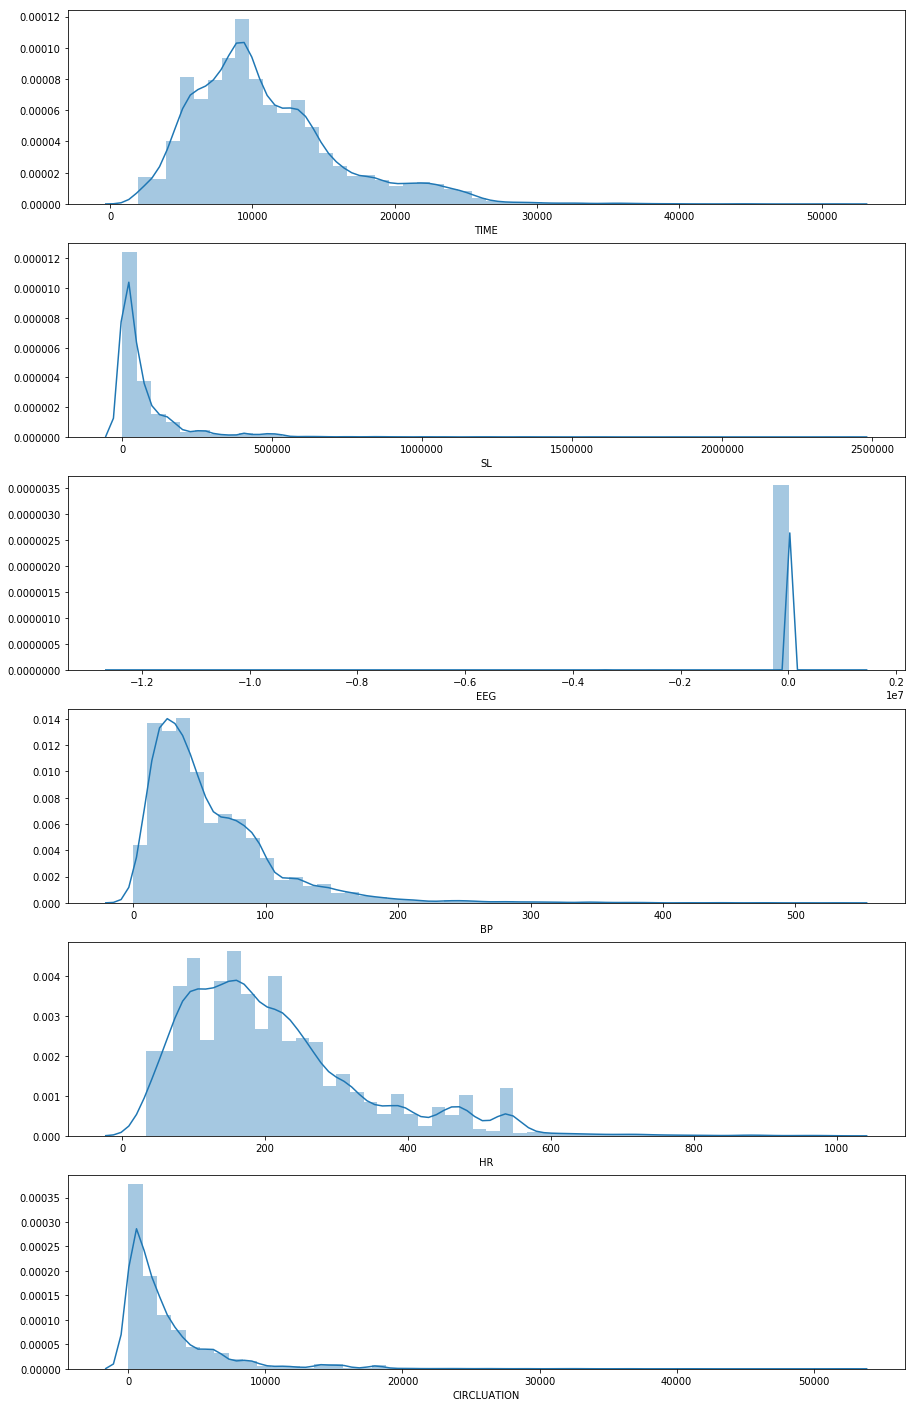

In [12]:
#creazione di grafici per osservare la distribuazione dei dati nelle varie features

cols=['TIME','SL','EEG','BP','HR','CIRCLUATION']
#Distribution
fig = plt.figure(figsize=(15, 25))
for i in range (0,len(cols)):
    fig.add_subplot(len(cols),1,i+1)
    sns.distplot(df[cols[i]]);

In [ ]:
#separazione dataset tra classi e features

target = df['ACTIVITY']
data = df.drop(['ACTIVITY'], axis=1)
data.head(10)

In [ ]:
#creazione dei modelli di classificazione

# 1 - SVM

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.05)

scaler = StandardScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
model = svm.SVC(kernel='rbf', gamma='scale')
model.fit(x_train, y_train)
model_predictions = model.predict(x_test)

print("SVM accuracy score: ", accuracy_score(y_test, model_predictions))

In [ ]:
# 2 - DecisionTree Classifier

from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
decision_tree_predictions = decision_tree.predict(x_test)

print("decision tree perecision: ", accuracy_score(y_test, decision_tree_predictions))

In [ ]:
# 3 - K-Nearest Neighbord

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_predictions = knn.predict(x_test)

print("K neighbors perecision: ", accuracy_score(y_test, knn_predictions))


In [ ]:
# 4 - Naive Bayes

from sklearn.naive_bayes import GaussianNB

native_bayes = GaussianNB()
native_bayes.fit(x_train, y_train)
native_bayes_predictions = native_bayes.predict(x_test)

print("native bayes perecision: ", accuracy_score(y_test, native_bayes_predictions))

In [ ]:
# 5 Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=2)
randomForest.fit(x_train, y_train)
randomForest_prediction = randomForest.predict(x_test)

print("RandomForest precision: ", accuracy_score(y_test, randomForest_prediction))


In [ ]:
# dato che il random forest classifier si è rivelato il migliore andiamo ad analizzare in dettaglio le feature
# che apportano il maggio contributo e un grafico rappresentativo

importances = randomForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomForest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],color="b", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
#plt.show()

In [ ]:
#confronto con kaggle.
# tutti coloro che hanno utilizzato un modello lineari hanno ottenuto degli score sotto lo 0,2 
# questo sta a significare che i classificatori lineari con un numero elevato di classi 
#non riescono a discrimare bene le soglie 